# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
df = pd.read_csv('data/cumulative.csv')

df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Disposition vs P_Disposition

Disposition (koi_disposition) is the category of the KOI from the Exoplanet archive. P_Disposition (koi_pdisposition) is the "pipeline flag that designates the most probable physical explanation of the KOI"

The difference between these two categories is not immediately clear. There is some overlap in the categories which would otherwise be separated.

We do some data wrangling to look at how these categories within the two columns match up and differ. 

In [3]:
print(df.koi_disposition.value_counts(),end='\n\n')
print(df.koi_pdisposition.value_counts())

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

FALSE POSITIVE    5068
CANDIDATE         4496
Name: koi_pdisposition, dtype: int64


We have some immediate observations:

1) There are three possible values for koi_disposition vs two values for koi_pdisposition

2) We can see here that the number of False Positives for each category is roughly the same, koi_pdisposition has 45 more False Positives

3) Going along with the first observation, without first looking at the actual value intersections, it appears that the Candidate value for koi_pdisposition can almost be split between the Confirmed and Candidate values in koi_disposition

To get a better idea of how these values align, we will 

a) Create a temporary dataframe looking only at rows which have a certain value in either column

b) Then look at the value counts of the other column.

In [4]:
#Initialize the dataframes with their corresponding conditional variables

d_falseposi = df[ df.koi_disposition == 'FALSE POSITIVE']
d_confirmed = df[ df.koi_disposition == 'CONFIRMED']
d_candidate = df[ df.koi_disposition == 'CANDIDATE']

disp_cols = [('False Positive', d_falseposi), ('Confirmed', d_confirmed), ('Candidate', d_candidate)]

dp_falseposi = df[ df.koi_pdisposition == 'FALSE POSITIVE']
dp_candidate = df[ df.koi_pdisposition == 'CANDIDATE']
             
dp_cols = [('False Positive', dp_falseposi), ('Candidate', dp_candidate)]
             
for value, dataf in disp_cols:
    print(value)
    print(dataf.koi_pdisposition.value_counts())
    
print(end='\n\n')
    
for value, dataf in dp_cols:
    print(value)
    print(dataf.koi_disposition.value_counts())


False Positive
FALSE POSITIVE    5023
Name: koi_pdisposition, dtype: int64
Confirmed
CANDIDATE         2248
FALSE POSITIVE      45
Name: koi_pdisposition, dtype: int64
Candidate
CANDIDATE    2248
Name: koi_pdisposition, dtype: int64


False Positive
FALSE POSITIVE    5023
CONFIRMED           45
Name: koi_disposition, dtype: int64
Candidate
CANDIDATE    2248
CONFIRMED    2248
Name: koi_disposition, dtype: int64


Now we have a more detailed look at how these columns are related.

Every single False Positive within the disposition column is also False Positive for p_disposition. Other the other hand, there are 45 False Positives for p_disposition that are actually listed as confirmed. There are 2248 candidates and confirmed that listed as just candidates for p_disposition.

In [5]:
id_cols = ['kepid', 'kepoi_name']

exo_archive_cols = ['kepler_name', 'koi_disposition']

project_disposition_cols = ['koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

transit_cols = ['koi_period', 'koi_time0bk', 'koi_eccen', 'koi_longp', 'koi_duration', 'koi_ingress', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_fittype', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor', 'koi_limbdark_mod', 'koi_parm_prov']

actual_transit = []
for col in transit_cols:
    if col in df.columns:
        actual_transit.append(col)

# Testing a model on the dataset

We are first going to run a Logistic Regression model without modifying the data too much. We are focusing on whether the model can correctly predict if a koi is a false positive or a confirmed exoplanet. We will need to modify the dataframe to exclude "candidate" kois.

In [6]:
df_excandidates = df[df.koi_disposition != 'CANDIDATE']

df_excandidates = df_excandidates.drop(columns=['koi_pdisposition'])

# Columns of interest

Although the dataset includes a lot of information in its columns and values, some of these columns are only meant to be values of confidence for other values, which are either directly observed or calculated by other means. We cycle through the available columns in the dataset and identify columns to use as our input for our model(s).

In [7]:
newline = 1

for col in df_excandidates.columns:
    if newline % 5 == 0:
        print(col, end='\n\n')
    else:
        print(col, end=' ')
    newline = newline + 1

rowid kepid kepoi_name kepler_name koi_disposition

koi_score koi_fpflag_nt koi_fpflag_ss koi_fpflag_co koi_fpflag_ec

koi_period koi_period_err1 koi_period_err2 koi_time0bk koi_time0bk_err1

koi_time0bk_err2 koi_impact koi_impact_err1 koi_impact_err2 koi_duration

koi_duration_err1 koi_duration_err2 koi_depth koi_depth_err1 koi_depth_err2

koi_prad koi_prad_err1 koi_prad_err2 koi_teq koi_teq_err1

koi_teq_err2 koi_insol koi_insol_err1 koi_insol_err2 koi_model_snr

koi_tce_plnt_num koi_tce_delivname koi_steff koi_steff_err1 koi_steff_err2

koi_slogg koi_slogg_err1 koi_slogg_err2 koi_srad koi_srad_err1

koi_srad_err2 ra dec koi_kepmag 

We identify the following features:

koi_period 
koi_impact 
koi_duration 
koi_depth 
koi_prad 
koi_teq 
koi_insol 
koi_model_snr 
koi_slogg
koi_srad


In [51]:
cols_of_interest = ['koi_period', 'koi_impact', 'koi_depth', 'koi_prad',
                    'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_slogg',
                    'koi_srad']

columns = ['kepid', 'koi_disposition'] + cols_of_interest

main_coi = df_excandidates.filter(items=columns)

main_coi

,kepid,koi_disposition,koi_period,koi_impact,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_slogg,koi_srad
0,10797460,CONFIRMED,9.488036,0.146,615.8,2.26,793.0,93.59,35.8,4.467,0.927
1,10797460,CONFIRMED,54.418383,0.586,874.8,2.83,443.0,9.11,25.8,4.467,0.927
2,10811496,FALSE POSITIVE,19.899140,0.969,10829.0,14.60,638.0,39.30,76.3,4.544,0.868
3,10848459,FALSE POSITIVE,1.736952,1.276,8079.2,33.46,1395.0,891.96,505.6,4.564,0.791
4,10854555,CONFIRMED,2.525592,0.701,603.3,2.75,1406.0,926.16,40.9,4.438,1.046
...,...,...,...,...,...,...,...,...,...,...,...
9556,8258160,FALSE POSITIVE,23.627035,1.096,8433.0,21.71,560.0,23.17,78.4,4.477,0.857
9559,10031643,FALSE POSITIVE,8.589871,0.765,87.7,1.11,929.0,176.40,8.4,4.296,1.088
9560,10090151,FALSE POSITIVE,0.527699,1.252,1579.2,29.35,2088.0,4500.53,453.3,4.529,0.903
9562,10147276,FALSE POSITIVE,0.681402,0.147,103.6,1.07,2218.0,5713.41,12.3,4.447,1.041


# Inspect and Explore our Data

We will be using this dataframe to train and then test our model.


## Inspecting for null and duplicated values

In [52]:
main_coi.isnull().sum()

kepid                0
koi_disposition      0
koi_period           0
koi_impact         300
koi_depth          300
koi_prad           300
koi_teq            300
koi_insol          259
koi_model_snr      300
koi_slogg          300
koi_srad           300
dtype: int64

In [53]:
((main_coi.isnull().sum() / len(main_coi)) * 100).round(2)

kepid              0.00
koi_disposition    0.00
koi_period         0.00
koi_impact         4.10
koi_depth          4.10
koi_prad           4.10
koi_teq            4.10
koi_insol          3.54
koi_model_snr      4.10
koi_slogg          4.10
koi_srad           4.10
dtype: float64

In [54]:
main_coi = main_coi.dropna()

In [55]:
main_coi.isnull().sum()

kepid              0
koi_disposition    0
koi_period         0
koi_impact         0
koi_depth          0
koi_prad           0
koi_teq            0
koi_insol          0
koi_model_snr      0
koi_slogg          0
koi_srad           0
dtype: int64

In [56]:
main_coi.duplicated().sum()

0

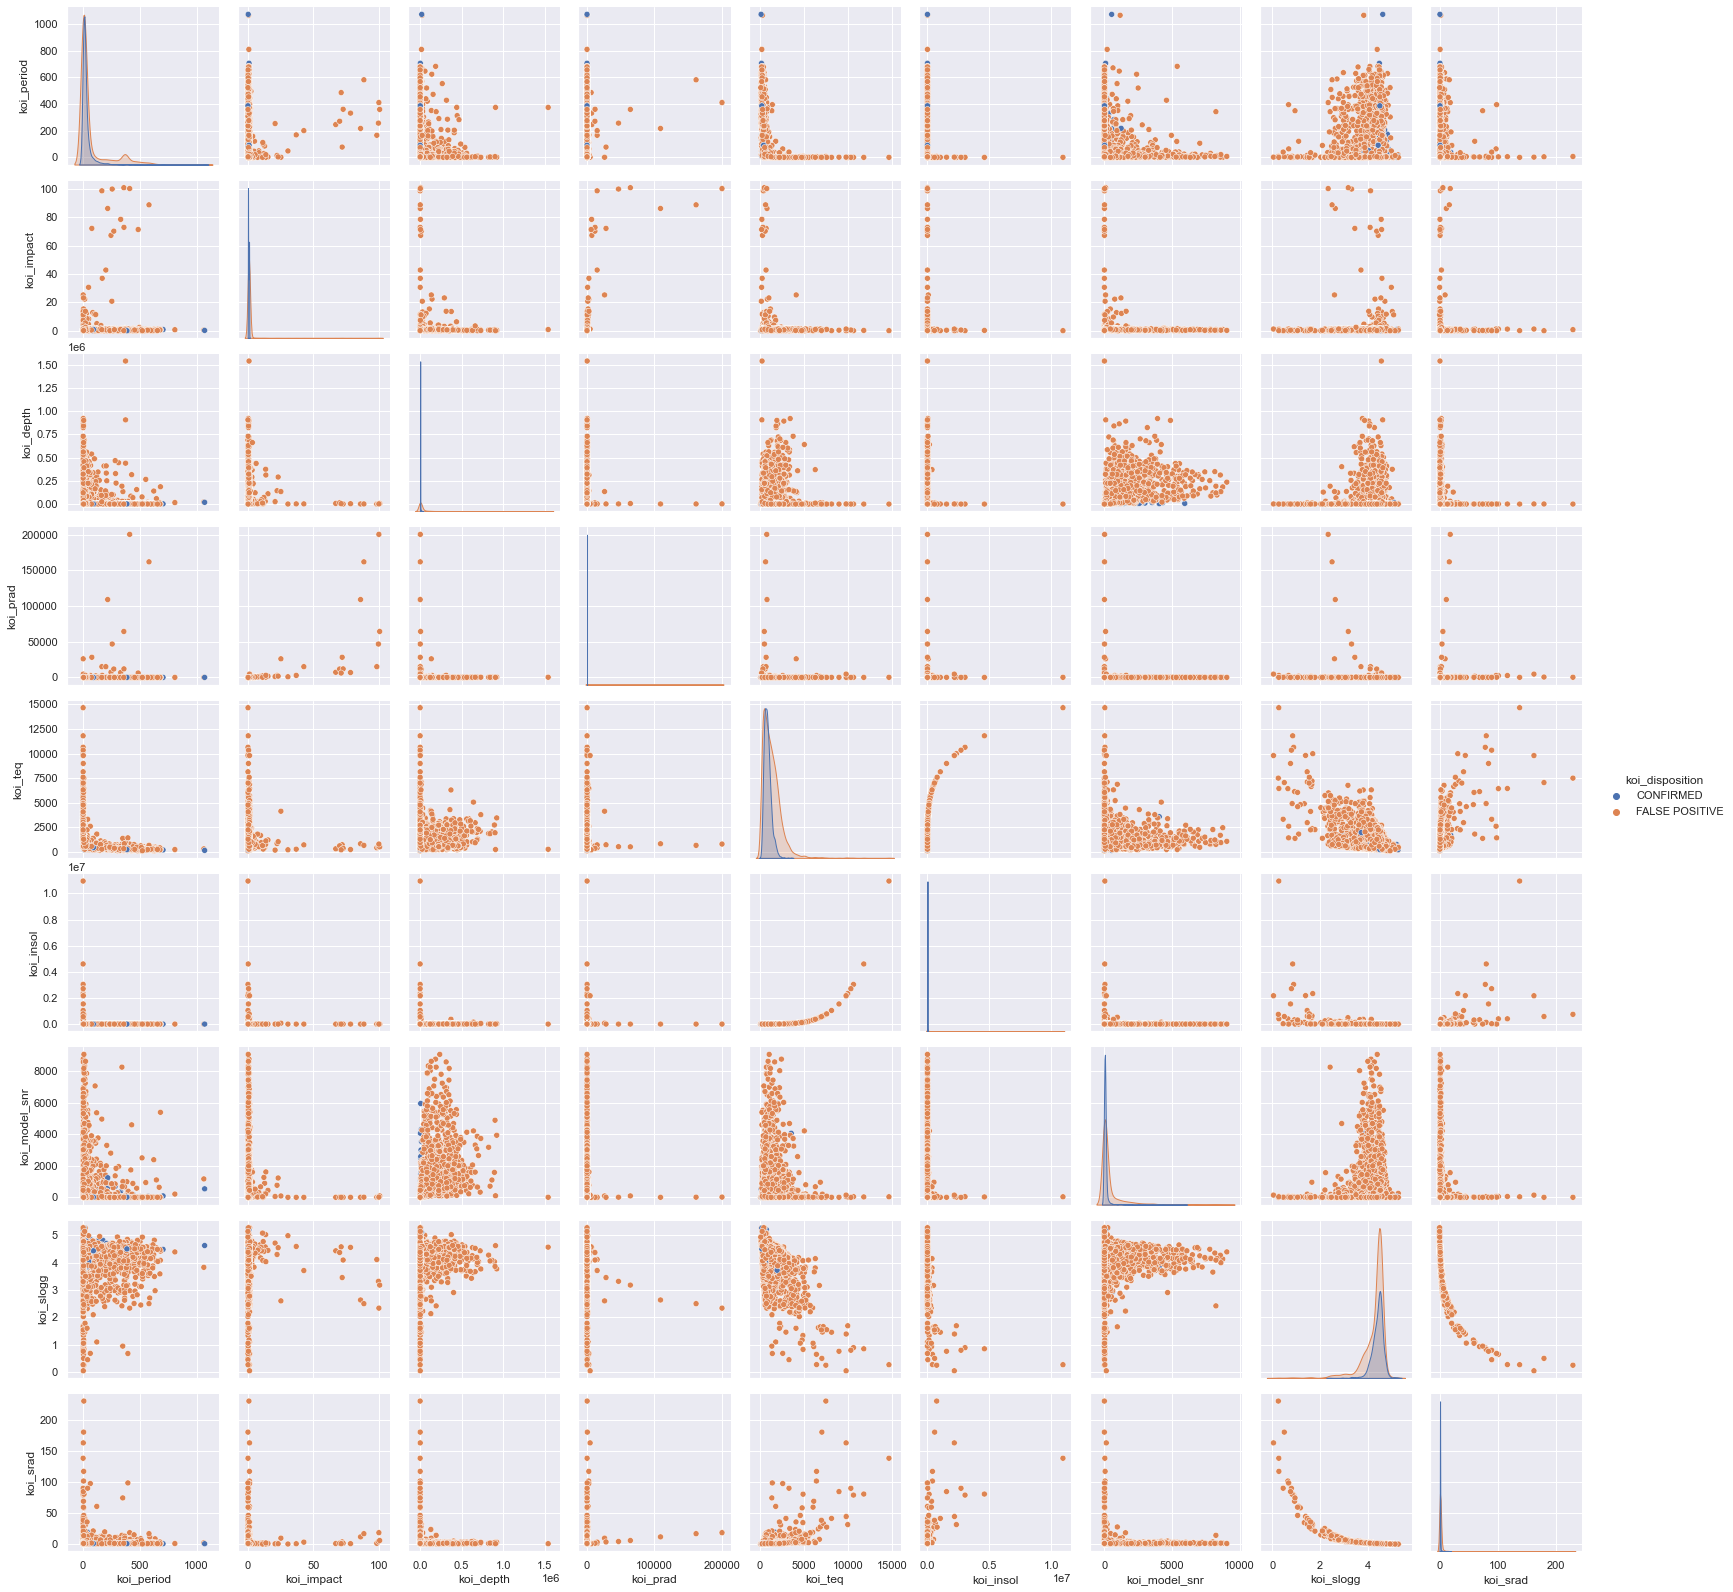

In [17]:
wo_kepid = main_coi.drop(columns='kepid')

sns.pairplot(wo_kepid, hue='koi_disposition')

We will test three features at a time, so we construct a power set of all the combinations length three of our columns of interest. We then
create a list of three random indices to select from the power set

In [35]:
from itertools import combinations
import random


selected_features = list(combinations(cols_of_interest, 3))
indices = []

for _ in range(3):
    indices.append(random.randint(0, len(selected_features) - 1))
    
indices


[71, 3, 23]

We then finally convert the koi_disposition values to continuous variables from string values

In [57]:
main_coi = pd.get_dummies(main_coi, columns=['koi_disposition'], drop_first=True)
main_coi.head()

,kepid,koi_period,koi_impact,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_slogg,koi_srad,koi_disposition_FALSE POSITIVE
0,10797460,9.488036,0.146,615.8,2.26,793.0,93.59,35.8,4.467,0.927,0
1,10797460,54.418383,0.586,874.8,2.83,443.0,9.11,25.8,4.467,0.927,0
2,10811496,19.899140,0.969,10829.0,14.60,638.0,39.30,76.3,4.544,0.868,1
3,10848459,1.736952,1.276,8079.2,33.46,1395.0,891.96,505.6,4.564,0.791,1
4,10854555,2.525592,0.701,603.3,2.75,1406.0,926.16,40.9,4.438,1.046,0


# Testing and training our model

* Select our three features
* Define our X and y
* Split our data into training and testing sets
* Train the model using `model.fit()` and the training data
* Evaluate how the model works with our testing data

In [58]:


for index in indices:
    features = list(selected_features[index])
    print(f"Selected features: {features}")
    X = main_coi[features]
    y = main_coi['koi_disposition_FALSE POSITIVE']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    
    model = LogisticRegression()
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}")


Selected features: ['koi_prad', 'koi_model_snr', 'koi_slogg']
Accuracy: 0.6246438746438746 
Precision: 0.6739702015775635
Recall: 0.8322510822510822
Selected features: ['koi_period', 'koi_impact', 'koi_insol']
Accuracy: 0.7478632478632479 
Precision: 0.7777777777777778
Recall: 0.8636363636363636
Selected features: ['koi_period', 'koi_insol', 'koi_slogg']
Accuracy: 0.6773504273504274 
Precision: 0.6858721389108129
Recall: 0.9404761904761905
